# Word Embedding Models: word2vec #

*Lauren F. Klein wrote version 1.0 of this notebook in 2019 based on the [Advanced Topics in Word Vectors workshop](https://dh2018.adho.org/en/machine-reading-part-ii-advanced-topics-in-word-vectors/) at DH 2018 as well as tutorials by [Radim Rehurek](https://rare-technologies.com/word2vec-tutorial/) and [Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/). It was updated again in 2021.* 

With thanks to Matt T.:

![oprah vector](http://lklein.com/wp-content/uploads/2021/10/oprah-everyone-3.png)

### Everything gets a vector! ###

We've actually already been exploring vectors involving words: consider scikit-learn's `CountVectorizer()`, for example, which we used to create the document-term matrix for our tf-idf calculations. That looked at words in relation to the documents in which they appeared. 

Today, however, we're going to look at words in relation to all other words in a corpus. The vectors that describe these types of relations are called, appropriately enough, *word vectors*. (And sometimes also *word embeddings*).

### What is a word vector? ###

A *word vector* or *word embedding* is a numerical representation of a word within a corpus, based on co-occurence with other words. Linguists have found that much of the meaning of a word can be derived from looking at its surrounding context. 

As a way into this idea, let's take a look at [an example of word vectors in action](http://benschmidt.org/profGender/).

### What is Word2Vec? ###

Word2vec is one popular approach to representing words in this numerical format. It's what Ben Schmidt used to make his website. Conveniently, word2vec is implemented in gensim, which we used last class for topic modeling, so we can use that library again.

Word2Vec is a *neural-network* or *deep learning* based approach of generating word vectors. 

There are many resources out there that will go into the heavy details of deep learning in general or deep learning for NLP such as Yoav Goldberg's Neural Network Methods in Natural Language Processing (Morgan & Claypool Publishers, 2017). Today, you'll get a high level overview -- just enough for you to understand what w2v is doing. 

### A Picture for Reference ###

Before we get into the details of neural networks and deep learning, let's take a quick look at an image that may help anchor some of the more heady concepts we're about to discuss. This shows us the word pairs for a tiny corpus, consisting of a single sentence, "The quick brown fox jumps over the lazy dog.” 

The words pairs from this sentence will constitute our training data: what we will use to generate our word vectors. I’ve used a small window size of 2 just for the example. Most of the time the window size will be slightly longer, like 5. In any case, the word highlighted in blue is the input word.

![skip-grams](http://mccormickml.com/assets/word2vec/training_data.png)

The neural network is going to learn the statistics from the number of times each pairing shows up. So, for example, the network is probably going to get many more training samples of (“brown”, “fox”) than it is of (“brown”, “unicorn”). When the training is finished, if you give it the word “brown” as input, then it will output a much higher probability for “fox” or “bear” than it will for “unicorn”.

But how are these probabilities generated, and what is a neural network anyway? Let's take a minute to talk through these ideas. 

### What is a neural network? ###

Here's great explainer adapted from Jer Thorp's recent book, [Living in Data](https://www.jerthorp.com/)

"A neural network is a mathematical model that traces its roots back to the 1940s, when logicians and neuroscientists and cyberneticians were trying to explain how the human brain learns. Taking a page from how actual neurons cells work, neural net pioneers conceived of a system of nodes, each a kind of simplified neuron. These notes hold a number, called an activation potential, above which a node will "fire," sending a signal to one or more other nodes; or, if there is no node to talk to, spitting out a result. Stitched together into collections (networks), these nodes showed the ability to recognize pattern; that is, to take a specific set of numeric inputs and to turn it, consistently, into an expected result."

"Imagine a group of thirteen children in a classroom, sitting in three neat rows of four, with one sitting alone in the back row. Each child can be given either a coookie or a nap. A cookie increases the kid's energy level by one; a nap reduces it by one. If a child's energy goes above a level ten, they have a tantrum, exhausting their excitement but also passing some of it on to any kids they may be connected to. Neural networks tend to be "feed-forward" meaning that the signal can only go in one direection from node to node. In our classroom, we can take this to mean that kids can pass energy back only to those sitting behind them."

"If we feed a plate of cookies to the kids in the front row, we can expect a wave of hysterics to pass from the front to the back of the class, ending with our lonely back-row student in tears. If every child in the front row got the same amount of sugar, and if they all had the same tolerance for it, this wave would be uniform, starting and ending with crying kids. Neural networks function the way they do, though, because the nodes aren't uniform; they are weighted. This meanas eveyr kid in our class has a different tolerance for cookies, a different level at which they'll break into a conniption. The wave of tears won't flow evenly from front to back, and the signal that we pass into the front won't be the same as the onen that comes out the back."

"Asuming the kids in the class are randomly weighted, each with a unique combination of patience and metabolism, feeding different numbers of cookies to the four kids in the front row would result in times when the back-row student loses their temper and times when they don't. Importantly, feeding the same pattern of cookies to the front of the class will always result in the same outcome in the back. This means that the classroom acts together as a pattern-recognition machine. Anything we might be able to translate into 'cookie language," a set of four numbers, can be fed into the machine to get a tantrum-based yes or no."

If the teacher wanted to make sure they got a specific reation from a specific piece of cookie code, they could reseat or replace the students, feeding the cookies to the front until the teacher saw the answer they wanted from the back. The teacher might train the class to recognize their birth year--2015--or the first four notes in "Baby Shark," or a binary representation for the number twelve. In a school assembly, with many more students, this same system could be arranged to recognize bigger sets of numbers, digitized words, or pixelated faces. More than that, a large network might be trained to recognize signals that are similar: faces that are smiling or words that rhyme with "cheese." A crucial point here is that the kids in the network don't need to know anything about the signal or the desired output. They just eat cookies, cry, nap, and compute."

Of course, we're not training a kids-and-cookies neural network. We're training a computational one with a far greater number of nodes. 

The important takeaway here, aside from how neural networks go from input to output, is that neural networks are not algorithms in themselves. They just go from start to finish. In order to make use of the input and output, they are most usually paired with algorithms that *train* the network, improving its performance over multiple iterations. 

Which brings us back to the word2vec algorithm and how it trains the neural network at its core.

### Training the neural network ### 

Here, we’re going to train our neural network to do something more complicated than predict whether a kid at the back of the room will cry or not. Our task is this: given a specific word in the middle of a sentence (the input word--like "brown," as in the image above), look at the words nearby and pick one at random. The network is going to tell us the probability for every word in our vocabulary of being the “nearby word” that we chose.

Let's look at our image again:

![skip-grams](http://mccormickml.com/assets/word2vec/training_data.png)

So "nearby" is actually defined by the "window size" parameter to the algorithm. A typical window size might be 5, meaning 5 words behind and 5 words ahead (10 in total). But in the image the window size is 2. 

We train the neural network to do this by feeding these word pairs, and he neural network is going to learn the statistics from the number of times each pairing shows up. 

**NOTE:** I've described something called the skim-gram methods of generating word vectors. THere's also another popular method called CBOW (continuous bag of words). The main difference is that while skip gram learns vectors by predicting the context words that come before and after our given word $w$, CBOW predicts the center word $w$ given context words.

### One more wrinkle / bonus  ###

One last wrinkle in the word2vec process is that, in the end, we’re not actually interested in the predictions generated by the model. What we're interested in is the weights of the nodes of the network itself. These are the actual "word vectors" that we want to work with. 

We can access them fairly easily because word2vec has only a single hidden (or "projection") layer, as displayed in the image below. 

![neural network](http://lklein.com/wp-content/uploads/2019/10/mikolov.png)

Conveniently, all you need is one hidden layer for a neural network to be classified as a "deep" network. So we're doing deep learning! Fancy!  

## Let's try it out!

### Import gensim, nltk tokenizers, glob, and Path

In [1]:
import gensim # remember this! 
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer
import nltk
nltk.download('punkt')
import glob
from pathlib import Path

/Users/lauren/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/Users/lauren/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidanc

### Read in our corpus

In [2]:
# next, we need to create our corpus.
# we'll use a new version of the Emory Wheel corpus, which I've cleaned a bit more since last time

import os

base_dir = "../corpora/wheel-clean/" 

all_docs = [] # our list which will store the text of each doc; empty for now

docs = os.listdir(base_dir) # get a list of all the files in the directory

for doc in docs: # iterate through the docs
    if not doc.startswith('.'): # get only the .txt files
        with open(base_dir + doc, "r", encoding="utf-8") as file: # force unicode conversion to keep PCs happy
            text = file.read() # read in the file as a single text string
            all_docs.append(text) # append it to the all_docs list

# lastly, just check the length of all_docs to see if it's 147
len(all_docs)

4008

### Preprocessing

gensim takes text at the level of `sentences` as its input. 

So let's define a function that a takes a list of texts (e.g. our all_docs list) and converts it into sentences for gensim word2vec to use. The function will lower-case text and tokenize by sentence and word.

In [3]:
# need our handy nltk tokenizer 
tokenizer = TreebankWordTokenizer()

# and we'll get titles
directory = "../corpora/wheel-clean/"
files = glob.glob(f"{directory}/*.txt")
wheel_titles = [Path(file).stem for file in files]

# and the function
def make_sentences(list_txt):
    all_txt = []
    counter = 0
    for txt in list_txt:
        lower_txt = txt.lower()
        sentences = sent_tokenize(lower_txt)
        sentences = [tokenizer.tokenize(sent) for sent in sentences]
        all_txt += sentences
        print(wheel_titles[counter]) # let's print the title of the article
        print("Sentences: " + str(len(sentences)))  # let's check how many sentences there are per article
        counter += 1
    return all_txt

In [4]:
# now let's run it
sentences = make_sentences(all_docs)

2017-09-06-White-Supremacist-Symbol-Tarnishes-Old-DeKalb-Courthouse
Sentences: 12
2017-09-13-Let-the-Games-Begin-Taylor-Swift-Satirizes-her-Reputation-in-NewSingles
Sentences: 32
2014-11-11-Crime-Report-11-11-14
Sentences: 16
2017-10-18-Doolino-Knows-Best-Falling-Apart
Sentences: 29
2016-11-23-Former-U-S-Poet-Laureate-to-Leave-Emory-for-Northwestern
Sentences: 23
2019-09-14-DeKalb-County-Issues-Boil-Water-Advisory
Sentences: 4
2015-10-24--Bob-s-Burgers-Going-Steady-Into-Season-Six
Sentences: 30
2016-03-21-The-Best-Batman-Film-is-One-You-Have-Probably-Never-Seen
Sentences: 35
2018-10-10-Great-Times-Await-at-Bad-Times-at-the-El-Royale-
Sentences: 29
2015-10-01-College-Is-Worth-More-Than-Advertised
Sentences: 22
2017-09-06-Emory-Doctors-Aid-Refugees
Sentences: 30
2018-09-12-Rose-Library-Honors-Curator-Randall-Burkett-s-Career
Sentences: 19
2014-10-21-Personhood-Not-Just-for-People
Sentences: 25
2018-09-25-Separation-of-Powers-Necessary-for-Student-Government
Sentences: 10
2017-04-05-Losin

2018-03-28-Emory-Community-
Sentences: 41
2018-04-11-MemEmory-Facilitates-School-Spirit
Sentences: 51
2019-09-25-Round-Table-Emory-Faculty-Discuss-Vaping-Vitamin-E-Epidemic
Sentences: 23
2016-07-11-Musicians-Behind-Swiss-Army-Man-Soundtrack-Talk-Scoring-Musical-Experimentation
Sentences: 28
2014-10-24-Office-of-LGBT-Life-MARBL-Launch-LGBT-Exhibit
Sentences: 4
2018-10-31-Voter-Suppression-Kemp-Revives-a-Racist-Past
Sentences: 13
2018-02-16-Fake-Migos-Concert-Booker-Faces-Federal-Fraud-Charges
Sentences: 27
2014-11-14-Full-Time-MBA-Program-Ranked-No-18
Sentences: 12
2015-02-23-Marvel-s-Studio-Snags-Spiderman
Sentences: 33
2017-02-22-Four-Students-Win-Bobby-Jones-Scholarship
Sentences: 13
2014-11-07-Editorial-Cartoon-11-7-14
Sentences: 1
2018-11-13-Girlpool-Displays-New-Sound-at-the-Masquerade
Sentences: 18
2019-03-06--Latino-is-a-Vague-Colonialist-Relic
Sentences: 31
2019-03-06-Emory-Must-Back-LGBTQ-Rights-Amid-Methodist-Rift
Sentences: 18
2018-11-06--Suspiria-is-Superficial-Not-Scary
Se

2017-10-25-Unaided-by-RSGA-Presidential-Debate-Proceeds
Sentences: 43
2018-04-17-Lil-Yachty-Desiigner-Attract-2-6k-Attendees
Sentences: 15
2019-04-03-After-Eviction-Notices-Dialogue-About-Palestine-is-Crucial
Sentences: 15
2019-09-10-Punk-s-Not-Dead-A-Small-Exhibit-that-Packs-Serious-Emotions
Sentences: 18
2019-10-01--Charlie-and-the-Chocolate-Factory-at-the-Fox-is-Chocolate-CoveredMediocrity
Sentences: 24
2017-09-13-The-Mediocre-Home-Again-Has-Its-Pleasures
Sentences: 22
2016-04-13-Baseball-Sweeps-NC-Wesleyan
Sentences: 28
2018-09-26--Smallfoot-Can-t-Reach-Pixar-s-Heights
Sentences: 39
2018-09-05-Eagles-Surpass-Generals-in-Sonny-Carter-Thriller
Sentences: 44
2015-12-02-A-Response-to-Black-Student-Activist-Demands
Sentences: 57
2017-10-03-Vegas-Massacre-Stuns-Emory
Sentences: 25
2017-10-25-Hamilton-Bests-Vettel-at-U-S-Grand-Prix
Sentences: 17
2017-02-07-Crime-Report-2-1-17
Sentences: 25
2019-02-06-News-Roundup-2-6-19
Sentences: 24
2019-03-05-Four-Emory-Seniors-Earn-Bobby-Jones-Scholars

2017-03-01-Sweep-Puts-Eagles-Back-on-Track
Sentences: 18
2017-03-29-Master-the-Lines-You-ll-be-Fine-A-Student-s-Manual-to-RidingMARTA
Sentences: 26
2018-04-10-SGA-and-GSGA-Induct-Newly-Elected-Members
Sentences: 19
2016-09-14--Atlanta-Brings-Issues-to-Light
Sentences: 31
2017-08-25-Dalai-Lama-Delays-Emory-Visit
Sentences: 19
2015-03-19-Alternative-Spring-Break-Provides-Immersion
Sentences: 25
2018-02-27-A-Gospel-of-Greed-Osteen-s-Lies
Sentences: 17
2017-08-30-Missiles-and-Messages-North-Korea-s-Provocation-of-the-UnitedStates
Sentences: 25
2016-09-07-Emory-Conducts-Research-on-Man-s-Best-Friend
Sentences: 37
2017-01-25-Undergrads-Grads-Divided-Over-Split
Sentences: 31
2015-04-13-On-Fire-4-13-15
Sentences: 17
2015-03-20-Emory-Alum-Civil-Rights-Reporter-Claude-Sitton-Dies-at-89
Sentences: 11
2018-01-25-Trump-s-Psychological-Health-Still-in-Question-Cognitive-ExamProves-Little-About-Fitness-for-Office
Sentences: 22
2017-10-02-Emory-Works-to-Eradicate-Ebola-Epidemic
Sentences: 26
2019-02-2

2017-10-05-Players-Right-to-Protest-NFL-Unfairly-Censors-Conservative-Speech
Sentences: 17
2018-08-10-Man-Behind-Migos-Scam-Sentenced-to-Almost-Four-Years-Orderedto-Pay-Restitution
Sentences: 9
2014-10-28-Black-Dog-Barks-Up-Right-Tree
Sentences: 17
2015-10-27-Yiks-Yaks-and-Threats-Oh-My-
Sentences: 27
2017-02-01-Tough-Competition-Brings-Out-Best-in-Track-and-Field-Team
Sentences: 30
2015-10-21-Evidence-Town-Hall-Elicits-Mixed-Student-Responses
Sentences: 22
2019-01-30-SGA-Declines-to-Advance-Impeachment-Process
Sentences: 25
2018-09-12-News-Roundup-9-12-18
Sentences: 14
2016-08-30-Emory-Sued-Over-Retirement-Plan-Fees
Sentences: 24
2018-02-14-The-Local-Pizzaiolo-New-Pies-Same-Old-Ideas-World-PizzaChampion-Opens-Westside-Spot
Sentences: 23
2017-02-01-Legislators-Revise-Proposed-Undergrad-Structure
Sentences: 7
2018-02-28-Art-s-Not-Dead-Emory-Arts-Underground-s-Festival-ofInsignificance-
Sentences: 26
2016-11-16-SGA-Grad-Undergrad-Split-Talks-Continue
Sentences: 17
2019-09-04-Callahan-s-C

2018-11-14-Volleyball-Sweeps-Berry-Regional-Advances-to-Quarterfinals
Sentences: 39
2016-10-19-Uncomfortable-Situations-Brought-to-You-by-SOC-101
Sentences: 17
2017-04-04-Crime-Report-4-5-17
Sentences: 21
2015-09-30-Police-Report-9-30-15
Sentences: 23
2017-11-07-University-Obtains-Archives-of-Prominent-African-AmericanPlaywright
Sentences: 18
2019-04-03-Track-Field-Stays-Hot-Finish-Top-5-in-Classic
Sentences: 14
2015-09-30-Style-Guide-Fall-Fashion-for-Optimal-Comfort
Sentences: 17
2018-10-03-International-Black-Student-Clubs-Could-Become-ExecutiveAgencies
Sentences: 38
2017-10-18-Yerkes-Accused-of-Negligence-Following-Animal-Deaths
Sentences: 20
2017-03-09-Crime-Report-3-8-17
Sentences: 34
2016-12-01-SGA-Restarts-Split-Bill-after-Violation-of-Constitution
Sentences: 13
2014-11-24-Men-and-Women-Compete-at-Nationals
Sentences: 17
2015-09-30-Our-Opinion-Rethinking-the-SAT
Sentences: 11
2015-03-24-Women-s-Swim-and-Dive-Wins-NCAA-D-III-Championships
Sentences: 22
2014-11-14-Etiquette-101-Th

2018-01-23-Patriots-Punch-Ticket-to-Super-Bowl-LII
Sentences: 20
2017-10-24-Ant-Venom-Could-Treat-Psoriasis-Emory-Researchers-Find
Sentences: 19
2015-10-01-The-Next-Genocide
Sentences: 20
2016-04-01-Final-Four-Championship-Yang-and-Burnside-Pick
Sentences: 38
2019-04-10-Critiques-of-Israel-Do-Not-Inherently-Constitute-Anti-Semitism
Sentences: 27
2016-04-06-Bazemore-and-Teague-Lead-Hawks-Past-Suns
Sentences: 16
2017-02-01-Uninformed-We-Cannot-Stand-The-Dangers-of-a-White-House-Waron-the-Press
Sentences: 18
2015-11-10-100-Senior-Honorary-Class-of-2016-Nominations-to-Close-Friday
Sentences: 11
2015-04-13-The-Pillars-of-a-Supportive-Community
Sentences: 27
2016-02-10-SGA-Revamps-University-Wide-Budgeting-System
Sentences: 21
2015-02-20-Barkley-Forum-Debates-Financial-Aid-for-Undocumented-Students
Sentences: 29
2016-05-17--Entrepreneurs-of-Care-Graduates-Commended-for-Initiative-Community-Engagement
Sentences: 17
2019-09-18-Reading-of-Homer-s-Iliad-Transports-Listeners-to-Ancient-Greece
Sen

2019-04-17-Wellness-Rooms-Touchdown-Workstations-Among-New-Facilities-inCampus-Buildings
Sentences: 15
2017-03-18--Common-As-Light-and-Love-Are-Red-Valleys-of-Blood-Paints-Vivid-Detailed-Pictures-of-Musician-s-Life
Sentences: 19
2015-12-20--The-Big-Short-Will-Make-You-Mad-as-Hell
Sentences: 35
2015-09-13-Students-Share-Ideas-at-TedxEmory-ATO-Salon
Sentences: 39
2018-04-04-Dorsey-Collins-Lift-Hawks-in-Magic-Matchup
Sentences: 25
2017-01-18-Vaught-Succeeds-McKay-as-Schwartz-Exec-Director
Sentences: 9
2018-06-28--Fallen-Kingdom-Spells-Extinction-for-Jurassic-Franchise
Sentences: 20
2015-04-02-Senior-Recognized-for-Global-Philanthropy
Sentences: 16
2019-01-23-Leonard-Pitts-Jr-Rebukes-Treatment-of-MLK-s-Legacy
Sentences: 14
2015-04-16-Beej-Knows-Best-Draft-Trade-Predictions
Sentences: 48
2018-02-06-News-Roundup-2-6-18
Sentences: 16
2015-04-24-The-People-Who-Inspire-Me
Sentences: 23
2014-10-06-Entire-Community-Affected-by-Hate
Sentences: 24
2019-02-19-Enku-Gelaye-Talks-Path-to-Emory-Greek-Li

2015-04-20--Jhalak-Offers-Glimpse-Of-Pakistani-Culture
Sentences: 16
2018-09-19-News-Roundup-9-19-18
Sentences: 14
2017-03-01-Munslow-Elected-Editor-in-Chief
Sentences: 25
2014-11-18-Ad-Hoc-Finds-Humor-Meaning-in-Dogfight-
Sentences: 25
2017-03-02-The-Experience-After-Emory-Roshani-Chokshi
Sentences: 31
2018-02-28--Annihilation-is-Bold-Sci-Fi-for-the-Environmental-Age
Sentences: 30
2018-02-13-Emory-Healthcare-Atlanta-Dream-Expand-Partnership
Sentences: 6
2019-09-17-Students-Amass-8-000-in-Five-Days-for-Hurricane-Relief
Sentences: 37
2017-04-18-Crime-Report-4-19-17
Sentences: 31
2017-03-01-News-Roundup-3-1-17
Sentences: 16
2018-10-05-MARTA-Board-Votes-to-Partially-Fund-Clifton-Corridor-Light-Rail
Sentences: 8
2014-11-18-Emory-Research-Receives-521-8-Million-in-2014
Sentences: 4
2017-11-29-Emory-A-J-Burgess-Forum-Explores-Social-Justice-Faith
Sentences: 16
2018-10-03-John-Legend-Urges-Students-to-Turn-Georgia-Blue
Sentences: 35
2018-02-21-Crime-Report-2-21-18
Sentences: 34
2015-12-12-A-C

2018-06-21--Tag-Scores-Laughs-Plays-by-The-Rules
Sentences: 28
2018-03-27-SGA-President
Sentences: 13
2019-04-01-Georgia-Abortion-Bill-Would-Hurt-State-s-Health-Economy
Sentences: 32
2019-04-17-Little-is-an-Adaptation-Worth-Watching
Sentences: 23
2015-02-27-Our-Pick-Genevieve-Roth
Sentences: 7
2016-02-10-Foege-to-Speak-at-Emory-Commencement
Sentences: 15
2018-09-19-Falcons-Shake-Off-the-Rust-Defeat-Panthers
Sentences: 27
2014-10-06-Crime-Report-10-7-14
Sentences: 17
2018-10-03-Bakery-Plants-Roots-at-Ponce
Sentences: 22
2018-05-30--The-Rider-Finds-Truth-in-the-American-Way
Sentences: 30
2018-04-06-Bench-pressed-Short-handed-Hawks-Can-t-Handle-the-Heat
Sentences: 19
2015-10-11-Art-by-Death-Row-Inmates-Addresses-Life-After-Death-
Sentences: 28
2018-11-05--The-Moors-Shines-With-Character-Depth
Sentences: 26
2019-09-04-Art-to-Consume-Before-College-Ends
Sentences: 30
2017-02-01-Q-The-Trumpets-Emory-s-Best-BBQ
Sentences: 21
2014-11-14-On-Fire-11-14-14
Sentences: 20
2014-11-11-Obama-Remains-R

2018-09-12-Timothy-Albrecht-is-Back-with-Bach-Live-Lier-
Sentences: 39
2019-09-18-Women-s-Golf-Makes-Its-Debut
Sentences: 12
2015-11-28-Club-Spotlight-Emory-Literary-Club
Sentences: 24
2015-03-19-ISIL-History-Points-to-United-States
Sentences: 52
2017-09-20-GSGA-Needs-Checks-and-Balances
Sentences: 8
2015-04-16-GOP-Bringing-1984-Party-to-Life
Sentences: 22
2019-03-06-Greta-Fails-to-Live-Up-to-Horror-Potential
Sentences: 28
2015-12-01-A-Conflict-of-Egos
Sentences: 47
2017-03-01-Burke-Represents-at-Region-2-Champs
Sentences: 18
2017-11-01-Ranked-UAA-Opponents-Derail-Women-s-Soccer
Sentences: 30
2018-02-06-GSGA-Executive-Member-Proposes-Transition-Plan
Sentences: 15
2017-09-20-Music-Midtown-s-Soulful-Performances-Make-Memories
Sentences: 39
2015-05-19-Pixar-Panel-Shows-the-Ins-And-Outs-of-Animation
Sentences: 16
2014-11-21-Emory-Tech-Tackle-Concussions-Head-On
Sentences: 10
2019-09-18-Emory-Routed-by-Washington-and-Lee-5-1
Sentences: 7
2015-04-20-Emory-Competes-Against-D-1-teams
Sentences

2017-02-06-Over-200-Faculty-Members-Ask-for-Sanctuary-Campus-Designation
Sentences: 27
2019-04-17-Students-Should-Not-Bear-the-Costs-of-Sustainability
Sentences: 19
2017-02-28-Oscars-Inspiring-Largely-Unsurprising
Sentences: 23
2014-10-02-Tuition-Policies-Harm-Undocumented-Students
Sentences: 35
2018-03-07-Koinonia-Coffee-Pops-Up-Then-Settles-Down
Sentences: 22
2018-03-28-Acceptance-Rate-Drops-to-18-5-Percent
Sentences: 14
2017-01-29-The-UN-Resolution-Anti-Israel-and-Anti-Semitic
Sentences: 28
2017-12-07-Nair-to-Leave-Emory-for-Arcadia-University-Presidency
Sentences: 27
2019-09-20-Daniel-Caesar-at-the-Fox-Theatre-Warring-in-the-Wake-ofControversy
Sentences: 25
2015-09-28-Street-Fighter-V-Reimagined
Sentences: 26
2015-12-16-The-Return-of-Star-Wars-The-Force-Reawakens-in-Episode-VII
Sentences: 69
2018-09-05-Ordal-Approved-as-Attorney-General-Elections-Board-Seats-Filled
Sentences: 23
2017-10-04-Warriors-Reign-Atop-NBA-power-Rankings
Sentences: 22
2016-09-07-Police-Report-09-07-2016
Sent

2017-11-01-The-Inaugural-Season-is-in-the-Books-But-the-Story-is-Just-Beginningfor-Atlanta-United
Sentences: 16
2018-10-18-ESNA-Doesn-t-Feel-Included-in-Club-Audit-Process
Sentences: 19
2017-11-14-SGA-Spends-2-241-22-on-Wonderful-Wednesday-After-DarkParaphernalia
Sentences: 8
2015-09-15-Campus-Reacts-to-President-Wagner-s-Departure
Sentences: 34
2017-08-30-When-Addressing-History-Actions-Speak-Louder-Than-Words
Sentences: 10
2019-01-30-Emory-s-Women-s-Basketball-Team-Dominates-in-Two-Home-Wins
Sentences: 21
2018-09-12-SGA-Discusses-Elections-Reform-Proposal
Sentences: 33
2015-10-21-Reproductive-Rights-Debate-is-a-Clash-of-Ethics
Sentences: 24
2015-03-18-How-to-Avoid-The-Second-Semester-Slump
Sentences: 29
2015-11-21-Paris-Social-Media-and-Us
Sentences: 25
2019-03-24-Crossword-3-20-19
Sentences: 73
2015-03-01-Eight-Faculty-Take-Home-Crystal-Apple-Awards
Sentences: 4
2018-09-18-Disney-s-Aladdin-at-the-Fox-Theater-Grants-All-of-Your-Wishes
Sentences: 26
2016-11-30-Wild-Goose-Chase-Jill-St

Sentences: 30
2019-02-13--Happy-Death-Day-2U-Like-Watching-the-Same-Movie-Over-and-OverAgain
Sentences: 37
2019-03-07-Crossword-3-6-19
Sentences: 66
2018-04-16-Whole-Foods-CEO-Sparks-Conversation-on-Meat-Consumption
Sentences: 27
2019-03-27-Congress-Must-Address-Bigotry-Rep-Omar-s-Controversial-Tweet-aRepublican-Scapegoat
Sentences: 21
2017-08-08-News-Roundup-8-8-17
Sentences: 41
2018-10-03-The-Almanac-of-Atlanta-s-Best-Acai-Bowls
Sentences: 31
2014-11-18-Task-Force-Details-Sexual-Violence-Prevention
Sentences: 9
2015-04-20-Asbury-House-Will-Open-to-Emory-Bayit-in-Fall
Sentences: 5
2015-04-20-No-1-Eagles-Dominate-Johns-Hopkins
Sentences: 15
2018-11-14--Ralph-Breaks-the-Internet-a-Timely-Worthy-Sequel
Sentences: 36
2018-03-05-Marthers-Named-Interim-Vice-President-of-Campus-Life
Sentences: 20
2014-11-25-On-Fire-11-25-14
Sentences: 9
2019-09-02-Bobby-Jones-Fellowship-Program-Suspended-for-at-Least-2-Years
Sentences: 12
2015-09-22-Service-Project-Spotlight-Love-Your-Melon
Sentences: 18
201

2018-09-26-Ma-s-College-Council-Probe-Went-Too-Far
Sentences: 24
2019-04-10-Coaches-Procure-Job-for-Longtime-DUC-Employee
Sentences: 53
2018-02-27-SGA-Funds-Charity-Event-Thankserving-
Sentences: 14
2016-03-08-Meeting-of-the-Minds-Open-Conversations-and-Free-Food
Sentences: 27
2018-04-04-Class-of-2018-Looks-Back-at-Emory-s-Best-Courses
Sentences: 39
2015-02-19-The-Cold-Weather-Manifesto
Sentences: 7
2018-12-25-Layne-Domingo-Talk-Bringing-Baldwin-to-Life-in-Beale-Street-
Sentences: 67
2018-09-12-New-Coaches-Join-Diving-Softball
Sentences: 25
2015-04-09-Nourish-International-Works-to-End-Poverty
Sentences: 22
2019-03-27-Peele-Successfully-Critiques-U-S-in-Us-
Sentences: 29
2016-02-21-Emory-Topples-NAIA-No-2-Georgia-Gwinnet
Sentences: 11
2014-10-30-School-Spirit-Found-in-Small-Moments
Sentences: 51
2019-01-23-Diversify-the-Voluntary-Core-Great-Books-Program-Could-UseBetter-Literature
Sentences: 25
2014-12-05-IFC-Ends-Social-Ban-Releases-Action-Plan
Sentences: 28
2018-03-07-A-New-Chapter-f

2015-04-20-Shaky-Knees-Festival-Will-Bring-Alt-Rock-Artists-to-Atlanta
Sentences: 17
2017-03-01-Penance-and-Absolution
Sentences: 23
2015-11-21-Changes-to-On-Campus-Housing-Received-Mixed-Reviews-fromStudents
Sentences: 19
2019-01-23-Warren-Qualified-But-Unelectable
Sentences: 22
2017-01-31-Emory-Alum-Joins-Trump-s-Team
Sentences: 10
2017-02-15-Sanctuary-Coalition-Rebuts-Sterk-s-and-Nair-s-Response
Sentences: 11
2016-11-14--Before-the-Flood-Lifts-Curtain-on-Climate-Change
Sentences: 16
2018-06-10-Oxford-Student-Mourns-Atlanta-s-Forgotten
Sentences: 36
2018-02-08-Emory-Eliminates-4-Year-B-S-M-S-Programs
Sentences: 11
2018-11-28-The-Halal-Guys-Unveils-Second-ATL-Spot
Sentences: 24
2015-03-19-Racial-Injustices-Inspire-Reaction-Through-Dance
Sentences: 20
2016-01-27-Panelists-Students-Debate-Freedom-of-Speech
Sentences: 28
2018-09-25-The-Wheel-Takes-TIFF-Day-One-9-11-
Sentences: 36
2015-09-01-Women-s-Soccer-hoping-to-build-on-Tournament-Appearence
Sentences: 19
2017-11-04-Emory-Files-Amicu

2017-02-08-Inequality-in-the-United-States
Sentences: 35
2018-10-06-Students-Faculty-Protest-Kavanaugh-in-Women-s-Rights-Rally
Sentences: 29
2015-04-17-Consciousness-Does-Not-Make-Humans-Supreme
Sentences: 27
2019-09-04-Hilsee-s-PK-Stuns-Sewanee-in-OT
Sentences: 17
2019-01-30--The-Current-Explores-Chilling-Mystery
Sentences: 32
2015-11-11-Jackie-Cruz-Gets-Personal-at-Culture-Shock
Sentences: 22
2019-09-11-Emory-Hosts-Forum-on-U-S-Measles-Outbreak
Sentences: 22
2016-10-15-Daft-Punk-s-Enigmatic-Rise
Sentences: 23
2016-09-30-Distefano-Delivers-Racy-Performance-in-Harland
Sentences: 31
2018-09-05-College-Council-Seeks-to-Fill-Vacant-Positions
Sentences: 9
2017-02-08-Goizueta-Scholar-Shares-Shoe-Flipping-Experience-StudentSpotlight-Devin-Gu-20
Sentences: 21
2019-04-03-Science-Journalist-Discusses-Antibiotics-Usage-in-Agriculture
Sentences: 11
2018-09-26-Freshmen-Weigh-In-On-Triple-Rooms
Sentences: 28
2016-04-19-Men-s-Tennis-Wins-Two-on-Road-Trip-to-Fredericksburg
Sentences: 13
2016-10-07-Fo

2018-10-31-Jessie-J-and-Kiana-Led-Take-it-Away-at-Buckhead-Theater
Sentences: 27
2017-02-22-News-Roundup-2-22-17
Sentences: 18
2017-08-29-Student-Governance-Services-Discontinues-Vendor-DepositPayments-Following-Migos-Scam
Sentences: 9
2016-04-20-Employee-Council-Town-Hall-Creates-Dialogue-Between-Faculty-Staff-and-Administrators
Sentences: 21
2016-05-08-Senior-Reflections-Brandon-Wagner
Sentences: 15
2017-08-29-Chemistry-Department-Updates-Curriculum
Sentences: 20
2018-02-14-Freshman-Romin-Williams-Love-for-Basketball-Shines-on-the-Court
Sentences: 41
2018-02-14-University-Admits-Three-Displaced-Puerto-Rican-Students
Sentences: 36
2015-04-13-alt-J-Concert-Compelling-Unique
Sentences: 18
2018-12-02-Travis-Scott-Combines-Nostalgia-New-Hits-on-Tour
Sentences: 22
2017-11-01-Falcons-Find-Footing-Escape-Jets-25-20
Sentences: 15
2017-03-31-Emory-Allies-With-30-Universities-Against-Revised-ImmigrationOrder
Sentences: 10
2019-09-08-College-Dean-Discusses-New-Faculty-Career-Resources-at-FirstCo

2014-12-04-At-Emory-No-Football-No-Problem
Sentences: 47
2016-10-04-A-Glimpse-Into-Trans-Life-at-Oxford-College
Sentences: 51
2018-09-26-Team-Snags-Eighth-Victory-of-Season
Sentences: 32
2018-02-21-Campus-Movie-Fest-Flaunts-Emory-s-Finest-Filmmakers
Sentences: 34
2018-10-16-Honor-Council-Report-10-17-18
Sentences: 13
2018-09-18-Three-Heart-Roastery-One-in-a-Melon-
Sentences: 17
2014-10-30-Kid-Dean-Debuts-New-Video
Sentences: 11
2016-02-03-Songs-that-Endure-Remembering-the-Eagles-Glenn-Frey
Sentences: 22
2017-11-29-XC-Teams-Claim-25th-Place-at-Nationals-Stravach-Closes-Careerwith-Impressive-Top-10-Finish
Sentences: 37
2017-02-01-Wary-of-Sanctuary-Status
Sentences: 11
2016-03-20-Hawks-Extend-Win-Streak-to-Four-Dismantle-Nuggets
Sentences: 22
2017-10-25-Professor-Dates-Ancient-DNA-in-Malawi
Sentences: 24
2018-03-07-Sterk-Talks-Boosting-Visibility
Sentences: 23
2019-02-27-News-Roundup-2-27-2019
Sentences: 14
2019-09-10-Arts-Funding-is-Missing-at-Emory
Sentences: 21
2016-06-16--The-Darkness

2017-03-29-SGA-Administrative-Budget-Drops-24-Percent
Sentences: 18
2019-04-17-Crime-Report-4-17-19
Sentences: 41
2015-04-07-Iran-Deal-A-
Sentences: 25
2017-12-27-From-Singing-to-the-Silver-Screen-Nick-Jonas-Talks-Jumanji-
Sentences: 26
2019-03-20-Baseball-Snaps-Losing-Skid
Sentences: 40
2019-04-11-Honor-Council-Report-4-10-19
Sentences: 9
2019-09-10-Climate-Crisis-Demands-Systemic-Change-Over-Individual-Action
Sentences: 26
2019-09-10-At-Emory-Funding-for-the-Arts-is-a-False-Prophet
Sentences: 21
2016-05-08-Senior-Reflections-Goldy-Tenreiro-Braschi
Sentences: 20
2017-01-24-SGA-Undergrads-Discuss-Proposed-Restructure
Sentences: 9
2017-02-08-Lady-Gaga-Strikes-Balance-Between-Politics-and-Performance
Sentences: 11
2015-03-27-We-Cannot-Quantify-Our-Experiences
Sentences: 25
2014-11-18-Everything-You-Need-to-Know-About-The-Theory-of-Everything-
Sentences: 41
2017-04-07-TEDx-Conjures-Magic-in-the-Air
Sentences: 28
2018-01-31-A-Very-Good-Boy-Brings-Very-Good-Vibes-CAPS-Introduces-NewCanine-S

2018-09-19--Mrs-Maisel-Marvels-GoT-Reclaims-Throne-at-Emmys
Sentences: 40
2018-01-31-Wolff-Whops-the-White-House
Sentences: 37
2017-03-21-Crime-Report-3-22-17
Sentences: 24
2015-03-24-We-Are-All-Interconnected-Not-Isolated
Sentences: 35
2017-02-08-Eagles-Fail-to-Produce-on-Road-Trip
Sentences: 36
2017-12-27-Hawks-Push-Past-Mavericks-After-Second-Half-Surge
Sentences: 27
2018-05-29-With-Solo-the-Cup-is-Half-Empty
Sentences: 34
2017-01-25-Immigration-in-the-Modern-American-Myth
Sentences: 30
2017-02-01-Wins-Keep-Eagles-in-UAA-Race
Sentences: 24
2017-03-01-Safety-Alliance-Stalls-Condominium-Development-Near-Emory
Sentences: 11
2017-10-24-Yancy-Urges-White-Students-Professors-to-Confront-Racism
Sentences: 16
2018-11-13--Overlord-is-Insane-and-Wild-Entertainment
Sentences: 24
2017-02-22-Why-a-Sanctuary-Campus-Matters-Georgia-s-Past-and-Present-andour-Nation-s-Future
Sentences: 16
2015-04-20-Be-Sociable-Send-Sticker-Messages
Sentences: 16
2017-09-10-Sotomayor-s-Emory-Visit-Cancelled-Due-to-S

2017-04-14-Israeli-Filmmaker-Explores-Conflict-in-Jerusalem
Sentences: 65
2016-10-25-People-of-Emory-Creating-Art-and-Facing-Adversity-BethanyStudnicky
Sentences: 44
2017-08-30-DUC-ling-Hacks-More-Bang-for-your-Beak-
Sentences: 18
2018-11-13-Jordan-Caple-Jr-Discuss-Returning-to-the-Ring-in-Creed-II-
Sentences: 61
2016-09-22-Police-Report-9-21-16
Sentences: 36
2016-09-21-Golf-Finished-Outside-of-Top-Ten-at-Fall-Preview
Sentences: 24
2018-11-07-Eagles-Season-Draws-to-a-Close
Sentences: 25
2017-11-08-The-Culture-of-Cosplay
Sentences: 27
2017-10-24-Post-Post-Malone-A-Concert-Review
Sentences: 19
2015-03-26-French-Major-Concentration-Pends-Approval
Sentences: 8
2015-09-20-A-Nuanced-View-On-Climate-Skepticism
Sentences: 51
2019-02-06-Crime-Report-2-6-19
Sentences: 38
2016-02-18-Biopic-Race-Has-Difficulty-Keeping-Up
Sentences: 21
2018-04-18-Barco-Makes-Dynamic-Debut-in-Draw
Sentences: 32
2017-02-14--I-Am-Not-Your-Negro-Explores-James-Baldwin-s-Role-in-the-CivilRights-Movement
Sentences: 25
20

2014-11-21-Sustainability-Security-Vital-to-Future-of-Food
Sentences: 39
2015-04-13-Film-Adaptation-of-The-Longest-Ride-Sparks-Timeless-Romance
Sentences: 21
2016-03-30-Baseball-Goes-2-1-on-Homestand
Sentences: 28
2016-09-22-FACE-Announces-DUC-Reconstruction-Delay-Addresses-MealSwipes-Policy
Sentences: 20
2014-10-21-Coke-Emory-Partner-For-Hackathon
Sentences: 14
2018-09-04-Crime-Report-9-5-18
Sentences: 35
2016-03-26-From-Icons-To-Experience-Tibetan-Iconography-Beckons-TheViewer-Into-An-Enlightened-World
Sentences: 21
2018-10-30-Pianist-Momoro-Ono-Dazzles-Audience-with-Classical-Pieces
Sentences: 25
2018-04-18-MSA-Art-Gala
Sentences: 1
2016-03-21-Emory-goes-undefeated-in-matches-against-Millsaps-and-Centre
Sentences: 9
2019-04-17-Eagles-Take-Over-First-Place-in-UAA-Standings
Sentences: 33
2016-03-14--That-Dragon-Cancer-Grief-And-Faith-Through-Gaming
Sentences: 39
2017-04-19-Reconsidering-the-Temporal-Plane-Before-Graduation
Sentences: 22
2018-03-07-Bazemore-s-29-Not-Enough-to-Halt-Warr

2014-11-04-From-the-Archives-Shock-Treatment-Electrifies
Sentences: 17
2016-11-09-SGA-Proposes-Graduate-Undergraduate-Split
Sentences: 16
2018-07-06-Rescission-of-Affirmative-Action-Guidelines-Won-t-Change-EmoryAdmission-Process
Sentences: 14
2016-04-20-A-Conservative-Against-Milo-Yiannopoulos
Sentences: 24
2018-02-14-News-Roundup-2-14-18
Sentences: 27
2018-10-22--Ohio-a-Brutal-Beautiful-Debut
Sentences: 27
2017-09-27--The-Investigation-is-Blunt-Harrowing
Sentences: 25
2019-01-02--Mary-Queen-of-Scots-Marred-by-Mediocrity
Sentences: 20
2018-10-20-Homecoming-Parade-Canceled-Due-to-Potential-Rain
Sentences: 11
2018-10-31-Midterm-Elections-Vote-for-the-Earth
Sentences: 22
2017-11-01-This-Season-s-Best-Podcast-Picks
Sentences: 30
2017-09-20-The-Experience-After-Emory-Stephen-Weizenecker
Sentences: 15
2016-11-02-Cross-Country-Struggles-in-UAA-Championship
Sentences: 32
2018-03-26-Nineties-Nostalgia-Cyberpunk-Scrunchies
Sentences: 21
2015-04-20-Excitement-Surrounds-The-Start-of-NBA-playoffs
S

2017-09-19-Eagles-Bounce-Back-After-Tough-Overtime-Defeat
Sentences: 20
2016-02-24-Students-Assemble-Wall-at-Dobbs-University-Center
Sentences: 12
2016-11-09-Emory-Doctors-Oppose-Proposal-to-Reallocate-Livers
Sentences: 17
2019-01-23-Firing-Cohen-Crossed-the-Line-It-s-Time-for-SGA-to-ImpeachPresident-Ma
Sentences: 26
2016-07-19--The-Shallows-Falls-Off-the-Deep-End
Sentences: 31
2016-11-02-Dear-Hillary-From-One-Nasty-Woman-To-Another
Sentences: 41
2017-01-31-Crime-Report-2-1-17
Sentences: 22
2015-09-15-Troyetsky-s-Pick-Ems-Week-2
Sentences: 29
2017-01-25-News-Roundup-1-25-17
Sentences: 19
2016-11-01-Doolino-Knows-Best-A-Festive-Drought
Sentences: 29
2016-10-27-Bangtan-Sonyeondan-Breaks-U-S-Musical-Language-Tradition
Sentences: 24
2017-04-19-Professor-Discusses-Disability-At-Emory-and-Abroad
Sentences: 29
2019-03-06-Nursing-Assistant-Dean-Finds-Passion-in-Pooches
Sentences: 28
2015-09-24-Review-Food-Trucks-at-Music-Midtown
Sentences: 20
2017-10-25-Duck-Donuts-is-a-Hole-in-One
Sentences: 

2016-03-15-Rose-Library-Obtains-Abolitionist-Text
Sentences: 14
2016-05-23-Emory-Baseball-Advances-to-College-World-Series
Sentences: 42
2017-02-15-Bill-Could-Mark-Noncitizen-Licenses
Sentences: 25
2016-11-16-Winter-Fashion-The-Weather-is-Getting-Cooler-and-so-Should-You
Sentences: 22
2017-03-29-The-Failure-of-Governance-at-Emory
Sentences: 25
2016-02-15--Deadpool-Understands-What-Makes-Its-Character-Popular
Sentences: 27
2015-10-21-Students-Revive-Emory-s-NAACP-Chapter
Sentences: 23
2017-04-12-Explaining-the-Greek-Crisis
Sentences: 16
2017-01-24-History-Remains-Relevant-in-The-Crucible-
Sentences: 19
2016-04-13-Committee-Completes-First-Presidential-Interviews
Sentences: 14
2015-09-11-Spotlight-on-Emory-Professors-at-the-Decatur-Book-Festival
Sentences: 15
2017-10-31-SGA-Votes-to-Create-Student-Concerns-Committee
Sentences: 19
2018-04-09-Stacey-Abrams-Talks-Gubernatorial-Goals-Ahead-of-Primaries
Sentences: 29
2017-03-22-Outdoor-Season-Begins-with-Strong-Home-Showing
Sentences: 13
2016

2018-09-19-Africa-CDC-Director-Stresses-Independent-Health-Systems
Sentences: 10
2018-11-07-Olympus-Brews-Up-Fresh-Flavors
Sentences: 19
2019-09-18--Hustlers-is-a-Fulfilling-Feminine-Crime-Drama
Sentences: 20
2015-04-06-Baseball-Takes-Three-Against-Huntingdon
Sentences: 32
2018-04-03-Let-s-Save-Net-Neutrality-While-We-Can
Sentences: 25
2019-02-06-SGA-s-Attack-on-the-Arts
Sentences: 13
2015-09-11-Honor-Council-9-11-2015
Sentences: 12
2014-11-18-Team-Ends-Season-After-NCAA-First-Round-Double-O-T-Loss-to-Berry
Sentences: 12
2015-09-18-Stromae-Delivers-Eccentric-Brilliant-Concert
Sentences: 13
2018-04-18-Crime-Report-4-18-18
Sentences: 36
2017-09-27-Provost-Talks-New-Admins-Grad-Union
Sentences: 25
2017-10-31--Let-the-baby-live-Dozens-Protest-Child-s-Transplant-Delay
Sentences: 32
2018-04-10-UPenn-Professor-s-Comments-Reveal-Systemic-Racism-in-HigherEducation
Sentences: 22
2019-02-10-Crossword-2-6-18
Sentences: 74
2016-03-26-Speech-Not-Silencing-Will-Defeat-Donald-Trump
Sentences: 47
2014-

## Train model

Now that we have our corpus ready for gensim, we can train the model. To do so, we call the function `gensim.models.Word2Vec()`. This function has a couple dozen parameters, some of which are more important than others.

Here are a few major ones. Only two are MANDATORY: these are marked with an asterisk:

1. `sentences*`: This is where you provide your data. It must be in a format of iterable of iterables.
2. `sg`: Your choice of training algorithm. There are two standard ways of training W2V vectors -- 'skipgram' and 'CBOW'. If you enter 1 here the skip-gram is applied; otherwise, the default is CBOW.
3. `size*`: This is the length of your resulting word vectors. If you have a large corpus (>few billion tokens) you can go up to 100-300 dimensions. Generally word vectors with more dimensions give better results.
4. `window`: This is the window of context words you are training on. In other words, how many words come before and after your given word. A good number is 4 here but this can vary depending on what you are interested in. For instance, if you are more interested in embeddings that embody semantic meaning, smaller window sizes work better. 
5. `alpha`: The learning rate of your model. If you are interested in machine learning experimentation with your vectors you may experiment with this parameter.
6. `seed` (int): This is the random seed for your random initialization. All deep learning models initialize the weights with random floats before training. This is a useful field if you want to replicate your experiments because giving this a seed will initialize 'randomly' deterministically.
7. `min_count`: This is the minimum frequency threshold. If a given word appears with lower frequency than provided it will be ignored. This is here because words with very low frequency are hard to train.
8. `epochs`: This is the number of iterations (entire run) over the corpus, also known as epochs. Default is 5. Usually anything between 1-10 is ok. The trade offs are that if you have higher iterations, it will take longer to train and the model may overfit on your dataset. However, longer training will allow your vectors to perform better on tasks relevant to your dataset.

Most of these settings will not concern us. As you'll see below, we are only going to use four arguments.

In [5]:
# let's train our model!
wheel_model = gensim.models.Word2Vec(
    sentences,
    min_count=2, # default is 5; this trims the corpus for words only used once; 
    vector_size=100, # size of NN layers; default is 100; higher for larger corpora
    workers=5) # parallel processing; needs Cython

Hooray! We have a trained word2vec model: `wheel_model`!

### Save model — and load it

It's often useful to save your trained model to disk so that you can reload it as needed. This is very similar syntax to saving topic models. 

In [6]:
wheel_model.save('wheel_model')

And you can load a model in the same way (remember this from our topic model)

In [6]:
old_model = gensim.models.Word2Vec.load('wheel_model') 

## Let's play!

### Similarity

word2vec can tell us which words, according to its model, are most similar to any other. We call `model.wv.most_similar("word", topn=number of similar words)`. Let's try `class`

In [8]:
# testing some basic functions

# basic similarity
wheel_model.wv.most_similar("class", topn=10)

[('classes', 0.6688558459281921),
 ('course', 0.6602054238319397),
 ('study', 0.6515331864356995),
 ('school', 0.619245707988739),
 ('room', 0.6138230562210083),
 ('semester', 0.6035787463188171),
 ('lecture', 0.6004877686500549),
 ('undergraduate', 0.5766473412513733),
 ('experience', 0.5733674764633179),
 ('classroom', 0.5647683143615723)]

Let's think about the results. `class` and `course` make intuitive sense: they have similar meanings to each other. But what's `study`? It's something you do for a class.

Our model's parallel invites our critical analysis: rather than take these results as *true*, we need to reflect, in part through turning to articles themselves and close reading them, on how the model arrives at its results, and what they might imply.

*Remember: everything the model knows it knows from our corpus. What we're learning are assumptions immanent to the corpus.*

## Exercise 1:

**Copy the code above and test out some words until you find one that has some interesting (or problematic) similar words.**

In [ ]:
# your answer here 

## Similarity between two words

We can choose specific words to compare with `model.wv.similarity(w1="word_one",w2="word_two")`

In [9]:
# similarity b/t two words

print(wheel_model.wv.similarity(w1="professor",w2="teacher"))
print(wheel_model.wv.similarity(w1="professor",w2="friend"))

0.6089441
0.43366995


As expected, the model believes that your professor is more similar to your teacher than your friend. 🙁

### Analogy

We can also play with analogy tasks. The commonly seen task is:

'Man is to King as Woman is to ____?'

The general structure is:
`A is to A\*  as  B is to B\*`
                         
gensim provides two different ways of implementing this task. You may be familiar with the the additive version also called the 3CosAdd method:

$$\underset{b*\in V}{\textrm{arg max}} (cos(b*,b) - cos(b*,a) + cos(b*,a*))$$

This reflects the abstraction of Woman - Man + King. In this maximization, we are searching which word vector will allow us to produce the highest value in this equation.

We can implement this method with a built-in function. Positive here refers to words that give the positive contribution to similarity (nominator), and negative refers to words that contribute negatively (denominatory). Here's the additive method.

In [25]:
# analogies
# format is: "man is to professor as woman is to ???"
# note that i'm using "she" and "he" here since they occur much more frequently in this particular corpus

result = wheel_model.wv.most_similar(positive=['she', 'professor'], negative=['he'])

print("{}: {:.4f}".format(*result[0])) # this prints the top result

english: 0.7234


Man is to woman as professor is to...english!? Ah, the bias of the model....

## Exercise 2:

**Copy the code above and test out some analogies until you find one that gets you some interesting (or problematic) results.**

In [ ]:
# your code here 

In [21]:
result = wheel_model.wv.most_similar(positive=['she', 'soccer'], negative=['he'])
print("{}: {:.4f}".format(*result[0])) # this prints the top result

volleyball: 0.7471


## There's so much more!

gensim has quite a few built-in tools, and it's worth taking some time to see what's available. Check the documentation here: [https://radimrehurek.com/gensim/models/keyedvectors.html](https://radimrehurek.com/gensim/models/keyedvectors.html)


## BONUS: Visualization!

Find below some code you can use to make visualizations from your word2vec model. We can't visualize all the many dimensions in our model, so we need to reduce them to two dimensions for our meager human brains. We do that with something called principal component analysis (PCA). 

Don't worry about the details for now. This is just a fun way to take a look at the output of our model. 

**Remember**: Our visualization reduces MANY dimensions to two, so a lot of information is lost.

In [9]:
### Let's do some visualization ###

import numpy as np

# Get the interactive Tools for Matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

/Users/lauren/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [10]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.vocab.keys()), sample)
        else:
            words = [ word for word in model.wv.vocab ]
        
#    word_vectors = np.array([model[w] for w in words]) <-- gensim 3 version
    word_vectors = np.array([model.wv[w] for w in words]) # gensim 4 version

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

<IPython.core.display.Javascript object>


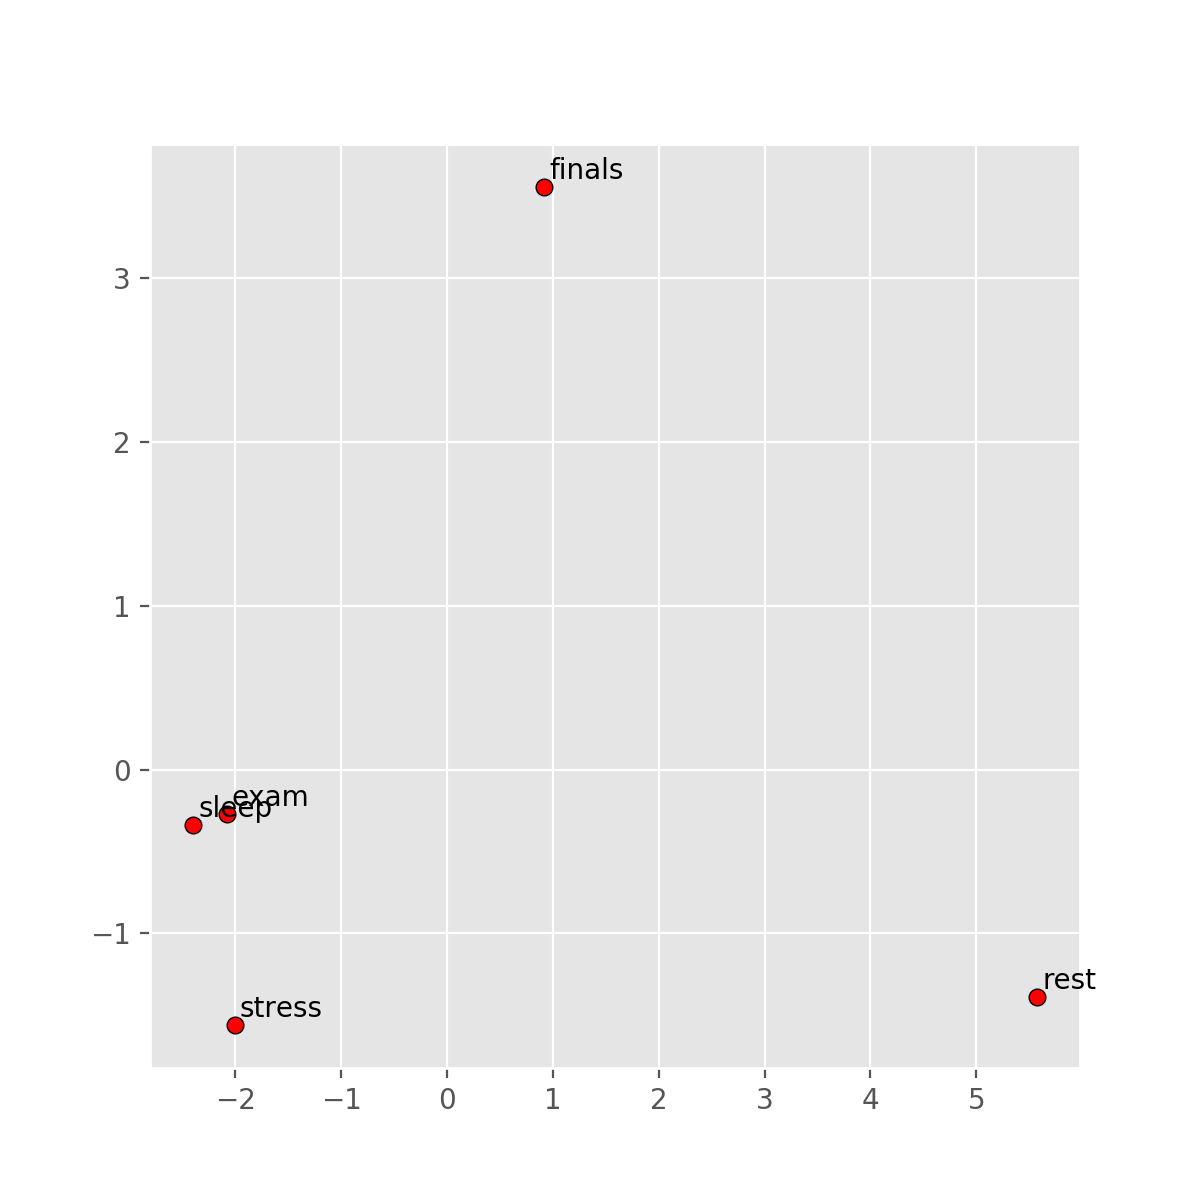

In [11]:
display_pca_scatterplot(wheel_model, ['exam','stress','finals','rest','sleep'])

# display_pca_scatterplot(ccp_model, sample=20)

## Exercise 3:

Play around with the words in the cell above to plot some words that you think might be similar or different from each other. What do you think the plot shows you about the words? Did they confirm or contradict what you though they would show?

In [ ]:
# type your answer here 